## Mini Projet Apprentissage Artificel : Groupe Paul Garnier - Arthur Verrez

(à rendre pour le vendredi 16/11/18)

Choix du sujet : Transfer Learning 

Nous allons utiliser le ConvNet construit par Google et notamment François Chollet : [Papier d'origine](https://arxiv.org/abs/1610.02357)

Le réseau se base sur des modules, que l'on présente ci-dessous : 

![inception-module](inception-module.png "Module Inception V3")

Chacun de ces modules vont "s'empiler" pour former notre réseau total. On présente sa forme complète ci-dessous : 

![xception](xception.png "Xception ConvNet")

C'est un réseau qui obtient de très bonnes performances, tout en limitant son nombre de paramètres (22 millions de paramètres). 

![xception-resultats](xception-resultats.png "Xception ConvNet")

## Mise en place du modèle : 

Nous allons commencer par mettre en place nos ConvNet, ainsi que les modules dont nous auront besoins : 

In [13]:
## Imports des différents modules, hors Keras: 
## ===============================

import os
import copy
import sys

# et pour l'affichage : 

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Pour Keras : 


from keras import backend as K
from keras import __version__

# Pour charger notre modèle : 
from keras.applications.xception import Xception, preprocess_input
from keras.models import Model
from keras.models import load_model

# Pour modifier notre modèle : 

from keras.layers import Dense, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Input, Flatten, Dropout
from keras.optimizers import SGD

# Pour modifier nos images et les utiliser : 

from keras.preprocessing.image import ImageDataGenerator
print("done.")

done.


Nous allons maintenant configurer les paramètres que nous allons utiliser :  

In [39]:
WIDTH, HEIGHT = 299, 299 #fixed size for InceptionV3
CHANNEL = 3
NB_EPOCHS = 10
BAT_SIZE = 3
FC_SIZE = 1024
NB_IMG_TRAIN = 50
NB_IMG_VAL = 5
nb_classes = 4
print("done.")

done.


On peut maintenant charger notre modèle : 

In [15]:
model_xception = Xception(input_tensor = Input(shape=(WIDTH,HEIGHT,CHANNEL)),
                          weights='imagenet', # On le prend, pre-trained sur imagesnet. 
                          include_top=False) # Pour enlever la couche Dense(1000) de classification
print("done.")

done.


On va maintenant construire nos fonctions pour le transfer learning. 

Globalement, cela représente : 

- une fonction pour modifier notre réseau (changer les dernières couches)
- une fonction pour freeze l'entrainement de toutes les couches, sauf la dernière
- une fonction pour freeze l'entrainement d'une nombre choisit de couches (fine tunning)


In [23]:
"""
On rajoute des nouvelles couches à notre modèle, et on le retourne

"""

def nouvelle_couche(model, nb_classes):
    x = model.output
    x = AveragePooling2D((10,10), padding='valid')(x) # On place un avg_pooling de taille 10x10 pour limiter les paramètres
    x = Dropout(0.5)(x) # On place du dropout, pour éviter l'overfitting.
    x = Flatten()(x) 
    x = Dense(1024,activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(nb_classes, activation='softmax')(x)
    new_model = Model(inputs=model.input, outputs=predictions)
    return new_model

print("done.")

done.


In [9]:
"""
On freeze l'intégralité des couches de notre premier modèle : ici le xception.
On compile ensuite notre modèle total et on affiche sa structure.
On renvoie aussi le nombre de couches.
"""

def freeze_full(new_model, model): 
    print("Nombre de couche dans le modèle de base := {}".format(len(model.layers)))
    for layer in model.layers:
        layer.trainable = False
    new_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    new_model.summary()
    
print("done.")

done.


In [10]:
"""
Ici, on ne freeze les couches que jusqu'à un certains index : 
"""

def freeze_some(new_model,model,indx):
    cpt = 0
    for layer in model.layers:
        layer.trainable = False
        cpt+=1
        if cpt == indx:
            break 
    new_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    new_model.summary()
    
print("done.")

done.


Il reste maintenant à mettre en place tout notre modèle.
Pour l'instant, on évite des choix de paramètres tricky, et on freeze tout le Xception de départ : 

In [24]:
# On rajoute nos couches à la fin 

model = nouvelle_couche(model_xception, nb_classes)

# On met en place le freeze : 

freeze_full(model,model_xception)

Nombre de couche dans le modèle de base := 132
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________

## Mise en place du dataset  : 

On s'interesse aux différentes expressions du visages. Nous allons utiliser 4 classes : 

- heureux
- neutre
- peur
- colère



On va utiliser les fonctionnalitées de Keras, on énonce d'abord nos différents paramètres : 

In [25]:
## Pour l'entrainement : 
#On limite ces paramètre, comme on travail sur des visages.

# ======================


rotationTrain = 5 
width_shiftTrain = 0.1
height_shiftTrain = 0.1
shearTrain = 0.1
zoomTrain = 0.05
flipTrain = False

## Pour les test : 

# ==============

rotationTest = 0. 
width_shiftTest = 0.1
height_shiftTest = 0.1
shearTest = 0.1
zoomTest = 0.05
flipTest = False

print("done.")

done.


On peut maintenant créer nos différents [ImageDataGenerator](https://keras.io/preprocessing/image/)
Les data pour les test et la validations seront les même. 

In [29]:


trainDataGenerator = ImageDataGenerator(
        rotation_range= rotationTrain,
        width_shift_range= width_shiftTrain,
        height_shift_range= height_shiftTrain,
        shear_range= shearTrain,
        zoom_range= zoomTrain,
        rescale=1./255,
        horizontal_flip= flipTrain,
        vertical_flip =  flipTrain,
        fill_mode='nearest')

testDataGenerator = ImageDataGenerator(
        rotation_range= rotationTest,
        width_shift_range= width_shiftTest,
        height_shift_range= height_shiftTest,
        shear_range= shearTest,
        zoom_range= zoomTest,
        rescale=1./255,
        horizontal_flip= flipTest,
        vertical_flip = flipTest,
        fill_mode='nearest')

print("done.")

done.


Les data sont en .zip sur GitHub. 
Elles sont placées en 2 dossiers : un training, et un validation. 
Chacun de ces deux dossiers comprend ensuite 4 dossiers : angry, frigthened, happy et neutral.

Ces différents dossiers comprennent les images que nous allons utiliser. 

## On met ici en place les directions pour ces dossiers (à changer modifier)

In [32]:


trainImg = '/Users/paulgarnier/Desktop/Files/Cours/Mines/2A/ApprentissageArtificiel/training/' 
validationImg = '/Users/paulgarnier/Desktop/Files/Cours/Mines/2A/ApprentissageArtificiel/validation/'

print("done.")

done.


Finalement, on lance nos dataGenerator avec ces images :  

In [40]:

trainGenerator = trainDataGenerator.flow_from_directory(
                    trainImg,
                    target_size=(WIDTH,HEIGHT),
                    batch_size=BAT_SIZE,
                    color_mode='rgb',
                    class_mode='categorical')
testGenerator = testDataGenerator.flow_from_directory(
                    validationImg,
                    target_size=(WIDTH,HEIGHT),
                    batch_size=BAT_SIZE,
                    color_mode='rgb',
                    class_mode='categorical') 
print("done.")

Found 60 images belonging to 4 classes.
Found 16 images belonging to 4 classes.
done.


## Entraînement du modèle : 

On peut maintenant entrainer le modèle, puis analyser nos résultats. 
On définit tout d'abord le nom de notre modèle pour pouvoir le save sur notre ordinateur.

In [34]:
saveName = "xception-face.model"
print("done.")

done.


In [42]:
## et on lance le training : 
## ========================

history = model.fit_generator(trainGenerator,
                              steps_per_epoch=NB_IMG_TRAIN/BAT_SIZE,
                              epochs=25,
                              validation_data=testGenerator,
                              validation_steps=NB_IMG_VAL,
                                 verbose=1) 


model.save(saveName)


Epoch 1/25
17/16 [==============================] - 23s 1s/step - loss: 12.3256 - acc: 0.2353 - val_loss: 13.4317 - val_acc: 0.1667
Epoch 2/25
17/16 [==============================] - 17s 1s/step - loss: 12.6416 - acc: 0.2157 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/25
17/16 [==============================] - 18s 1s/step - loss: 12.0096 - acc: 0.2549 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/25
17/16 [==============================] - 18s 1s/step - loss: 11.6935 - acc: 0.2745 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 5/25
17/16 [==============================] - 18s 1s/step - loss: 12.6416 - acc: 0.2157 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 6/25
17/16 [==============================] - 18s 1s/step - loss: 12.3256 - acc: 0.2353 - val_loss: 5.3727 - val_acc: 0.6667
Epoch 7/25
17/16 [==============================] - 18s 1s/step - loss: 11.6935 - acc: 0.2745 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 8/25
17/16 [==============================] - 17s 1s/step - l

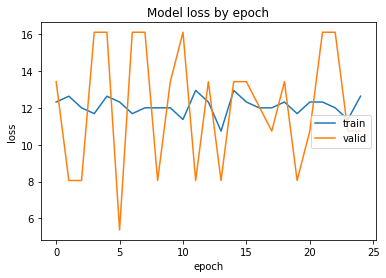

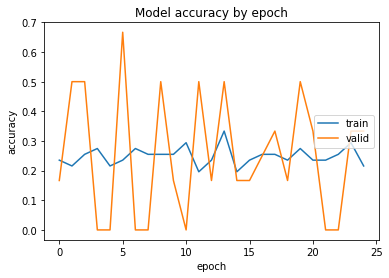

In [43]:
## et on affiche les différents résultats : 
## =======================================

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'valid'], loc='right')
plt.xlabel('epoch')
plt.show()